> THIS NOTEBOK REQUIRES THE `convert_ids.ipynb` and a good portion of `preprocessing.ipynb` TO BE RAN FIRST

# Ordering Characters in Movies by importance
The website [TMDB claims that](https://www.themoviedb.org/bible/movie/59f3b16d9251414f20000003#59f73ca49251416e7100000e) roles for characters are ordered by importance, namely that major roles are always credited before small parts. 

Let's scrape that data and add that to our dataframe of `name_by_movie_df.csv`

In [1]:
import requests
import pandas as pd
import numpy as np
from IPython.display import clear_output

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Import token from config.py
from config import TMDB_API_TOKEN

In [3]:
raw_dir = '../raw_data/'
tmp_dir = '../tmp_data/'
processed_dir = '../processed_data/'

## Scraping the data

In [4]:
# Request setup
headers = {
    "accept": "application/json",
    "Authorization": f"Bearer {TMDB_API_TOKEN}"
}

def fetch_url(movie_id):
    """Fetches the url for a given movie ID"""
    url = f"https://api.themoviedb.org/3/movie/{movie_id}/credits?language=en-US"
    return url

In [5]:
test_id = 577922

# Request the pageprops for a page
response = requests.get(fetch_url(test_id), headers=headers).json()

In [6]:
# Import ids dataframe
external_ids = pd.read_csv(tmp_dir + 'movies_external_ids.csv')
display(external_ids.head())

# Import name_by_movie dataframe
name_by_movie = pd.read_csv(tmp_dir + 'name_by_movie_df.csv')
display(name_by_movie.head())

# To save time, only consider the tmdb_ids that are in the name_by_movie dataframe
tmdb_ids_list = name_by_movie.merge(external_ids, left_on='wiki_ID', right_on='wikipedia_ID')['TMDB_ID'].dropna().astype(int).astype(str).unique()
display(tmdb_ids_list.shape)

# Set TMDB_ID as index
print(f"Is the TMDB_ID column in external_ids unique? {external_ids['TMDB_ID'].dropna().is_unique}")
lookup_ids = external_ids.dropna(subset=['TMDB_ID']).set_index('TMDB_ID').copy(deep=True)
display(lookup_ids.head())

,wikipedia_ID,IMDB_ID,TMDB_ID
0,22760465,ch0112831,NaN
1,185519,nm0158560,NaN
2,12754957,nm0704910,NaN
3,10111255,nm1016169,NaN
4,7669437,tt0000001,16612.0


,wiki_ID,char_words,gender
0,975900,Lieutenant,F
1,7668793,Lieutenant,M
2,24226493,Lieutenant,M
3,3388805,Lieutenant,M
4,8231713,Lieutenant,M


(27181,)

Is the TMDB_ID column in external_ids unique? True


,wikipedia_ID,IMDB_ID
TMDB_ID,,
16612.0,7669437,tt0000001
16613.0,9996498,tt0000002
88013.0,6431647,tt0000003
16622.0,9999926,tt0000004
16624.0,73372,tt0000005


While running the code below, we realised that there was an overwhelming amounts of uncredited characters indicated by `(uncredited)` in the TMDB data, which didn't have any name. We decided to remove these characters from our analysis, as they would not be useful, to save space

In [ ]:
# For every movie ID (TMDB IDs), request the credits
tmp_ids = []
tmp_names = []
tmp_order = []
tmp_gender = []

for movie_id, idx in zip(tmdb_ids_list, range(len(tmdb_ids_list))):
    # Skip until idx is 15516
    if idx < 15516:
        continue

    # Request
    url = fetch_url(movie_id)
    response = requests.get(url, headers=headers).json()

    # If case doesn't exist, skip
    if 'cast' not in response or not response['cast']:
        continue    

    # Response contains a list called cast, an ordered list of characters by importance
    for char in response['cast']:
        # If name contains '(uncredited)' or '(voice)', skip
        if '(uncredited)' in char['character'] or '(voice)' in char['character']:
            continue

        # Store values
        tmp_ids.append(movie_id)
        tmp_names.append(char['character'])
        tmp_order.append(char['order'])
        tmp_gender.append(char['gender'])

    # Prettyyyy progress
    clear_output(wait=True)   
    print(f"Finished {idx+1}/{len(tmdb_ids_list)} ({movie_id})")

# Save the credits in a dataframe
credits_df = pd.DataFrame({'TMDB_ID': tmp_ids, 'credits': tmp_names, 'order': tmp_order, 'gender': tmp_gender})
credits_df['credits'] = credits_df['credits'].str.split() # Split the names into a list by space
credits_df = credits_df.explode('credits')
display(credits_df)

# Save as tmp
credits_df.to_csv(tmp_dir + 'credits_tmp_df.csv', index=False)

Let's perform some simple processing on the dataset we've just scraped:

In [7]:
# Drop the duplicate on tmdb_id, credits and gender, but we keep the one that has the lowest order
credits_sorted_df = credits_df.sort_values(by='order', ascending=True)
credits_cleaned_df = credits_sorted_df.drop_duplicates(subset=['TMDB_ID', 'credits', 'gender'], keep='first').copy(deep=True)
display(credits_cleaned_df)

# There are roles with gender 0,3 = none, 1 = female, 2 = male
display(credits_cleaned_df.groupby('gender').count())

# Show how many genders are not 1 or 2
print(f"There are {credits_cleaned_df[(credits_cleaned_df['gender'] != 1) & (credits_cleaned_df['gender'] != 2)].index.shape[0]} roles without any gender equal to 1 or 2")

# Save in tmp
credits_cleaned_df.to_csv(tmp_dir + 'credits_gender_df.csv', index=False)

,TMDB_ID,credits,order,gender
0,10016,Lt.,0,1
781489,3117,Baron,0,2
781490,3117,Victor,0,2
781491,3117,Frankenstein,0,2
781492,3117,aka,0,2
...,...,...,...,...
1000116,2897,Fan,310,2
1000115,2897,Held,310,2
1000114,2897,Hand,310,2
1000113,2897,Operating,310,2


,TMDB_ID,credits,order
gender,,,
0,155886,153367,155886
1,221663,219015,221663
2,475834,471855,475834
3,271,269,271


There are 156157 roles without any gender equal to 1 or 2


## Merging the data with characters dataframe

<Axes: xlabel='credits'>

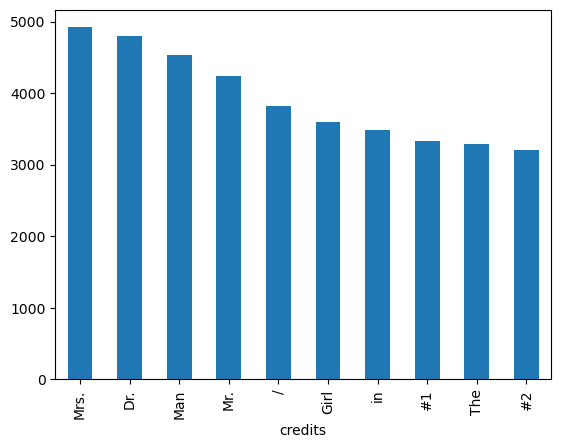

In [8]:
# Import credits_df
credits_df = pd.read_csv(tmp_dir + 'credits_gender_df.csv')

# Plot for fun the top 5 most used character names
credits_df['credits'].value_counts().head(10).plot(kind='bar')

# There are a lot of titles (officer, doctor, ...) but this is all taken care
# of when merging with the name_by_movie dataframe

We now want to merge the credits_df (b) with the name_by_movie (a) dataframe. Matching the character names bits to movie_id is easy. However for the genders it's a bit tricky:
- If we have a value M or F in (a), we ideally want to get the data from (b) with the matched gender.
    - If we have M in (a) and M in (b), we match that order value
    - If we have M in (a) and F in (b), we discard that order value and put NaN
- If we have NaN in (a) and either M or F in (b), we match that order value of the one that is lower in order.

We first merge the two dataframes through a left join on `movie_id` and `char_words` (the name), ignoring genders and creating all possible combinations.

Lets put these rules into code as a `adjust_order` function. It will overwrite the order value:

In [9]:
def adjust_order(row):
    if pd.notna(row['gender_x']) and pd.notna(row['gender_y']):
        # If gender is specified in both and matches, keep the order from (b)
        if row['gender_x'] == row['gender_y']:
            return row['order']
        else:
            # If gender does not match, set order to NaN = row is not a valid match
            return np.nan
    elif pd.isna(row['gender_x']):
        # If gender is NaN in (a), take the order from (b)
        return row['order']
    else:
        # When gender is missing from our original df, we keep the order regardless of the gender
        return row['order']

Overwriting the order value will help us eliminate those that we ha overwritten/invalidated, and then we'll remove them:

In [10]:
# Update the credits_df genders so that 1 is female, 2 is male, 0 is NaN
gender_map = {1: 'F', 2: 'M', 3: np.nan, 0: np.nan}
credits_df_gender_mapped = credits_df.copy(deep=True)
credits_df_gender_mapped['gender'] = credits_df_gender_mapped['gender'].map(gender_map)

# Add the wiki_ID to the credits_df with the help of the lookup table
credits_df_wiki_ids = credits_df_gender_mapped.merge(lookup_ids, left_on='TMDB_ID', right_index=True).copy(deep=True)
# display(credits_df_wiki_ids)

# Merge the credits_df with the name_by_movie dataframe
name_with_order = name_by_movie.merge(credits_df_wiki_ids, left_on=['wiki_ID', 'char_words'], right_on=['wikipedia_ID', 'credits'], how='left').copy(deep=True)
display(name_with_order)

# Adjust the order
name_with_order['adjusted_order'] = name_with_order.apply(adjust_order, axis=1)
display(name_with_order)

# Sort by adjusted order and keep first best occurence of wiki_ID, char_words and gender_x
name_with_order_sorted = name_with_order.sort_values(by='adjusted_order')
unique_characters = name_with_order_sorted.drop_duplicates(subset=['wiki_ID', 'char_words', 'gender_x'], keep='first')
display(unique_characters)

# Keep only important comulmns: wiki_ID, char_words, order
name_with_order_clean = unique_characters[['wiki_ID', 'char_words', 'order', 'gender_x']].copy(deep=True)
name_with_order_clean = name_with_order_clean.sort_values(by='wiki_ID')
# rename columns for consistency
name_with_order_clean.columns = ['wiki_ID', 'char_words', 'order', 'gender']
display(name_with_order_clean)

,wiki_ID,char_words,gender_x,TMDB_ID,credits,order,gender_y,wikipedia_ID,IMDB_ID
0,975900,Lieutenant,F,NaN,NaN,NaN,NaN,NaN,NaN
1,7668793,Lieutenant,M,865.0,Lieutenant,27.0,M,7668793.0,tt0093894
2,24226493,Lieutenant,M,74484.0,Lieutenant,2.0,M,24226493.0,tt0023706
3,3388805,Lieutenant,M,34379.0,Lieutenant,3.0,M,3388805.0,tt0093638
4,8231713,Lieutenant,M,208566.0,Lieutenant,3.0,M,8231713.0,tt0325043
...,...,...,...,...,...,...,...,...,...
186375,24341999,Dagen,M,41439.0,Dagen,4.0,M,24341999.0,tt1477076
186376,43452,Auda,M,947.0,Auda,2.0,M,43452.0,tt0056172
186377,11372598,Bonni,M,NaN,NaN,NaN,NaN,NaN,NaN
186378,2472440,Kary,M,34314.0,Kary,11.0,M,2472440.0,tt0120390


,wiki_ID,char_words,gender_x,TMDB_ID,credits,order,gender_y,wikipedia_ID,IMDB_ID,adjusted_order
0,975900,Lieutenant,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7668793,Lieutenant,M,865.0,Lieutenant,27.0,M,7668793.0,tt0093894,27.0
2,24226493,Lieutenant,M,74484.0,Lieutenant,2.0,M,24226493.0,tt0023706,2.0
3,3388805,Lieutenant,M,34379.0,Lieutenant,3.0,M,3388805.0,tt0093638,3.0
4,8231713,Lieutenant,M,208566.0,Lieutenant,3.0,M,8231713.0,tt0325043,3.0
...,...,...,...,...,...,...,...,...,...,...
186375,24341999,Dagen,M,41439.0,Dagen,4.0,M,24341999.0,tt1477076,4.0
186376,43452,Auda,M,947.0,Auda,2.0,M,43452.0,tt0056172,2.0
186377,11372598,Bonni,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN
186378,2472440,Kary,M,34314.0,Kary,11.0,M,2472440.0,tt0120390,11.0


,wiki_ID,char_words,gender_x,TMDB_ID,credits,order,gender_y,wikipedia_ID,IMDB_ID,adjusted_order
41094,23659207,Andy,M,40722.0,Andy,0.0,M,23659207.0,tt1241017,0.0
42293,2584080,Red,F,44515.0,Red,0.0,F,2584080.0,tt0119552,0.0
42291,444767,Red,M,4464.0,Red,0.0,M,444767.0,tt0329575,0.0
42284,4851596,Red,M,69419.0,Red,0.0,M,4851596.0,tt1039983,0.0
42280,6600698,Red,F,213614.0,Red,0.0,F,6600698.0,tt0089878,0.0
...,...,...,...,...,...,...,...,...,...,...
186365,19437810,Zinia,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN
186369,11952284,Rotha,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN
186370,27945099,Fedora,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN
186372,5971762,Dyle,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,wiki_ID,char_words,order,gender
44683,3217,Gold,6.0,NaN
40621,3217,Linda,7.0,F
12252,3217,Henry,4.0,M
60719,3217,Duke,4.0,M
174320,3217,Warrior,9.0,M
...,...,...,...,...
44937,37478048,Ajay,9.0,M
97102,37501922,Murphy,3.0,F
116082,37501922,Hunter,1.0,M
2804,37501922,John,1.0,M


In [11]:
# Compute how many characters don't have an order
print("Number of character names with an order: {} out of {} ({:.2f}%)".format(name_with_order_clean['order'].notna().sum(), name_with_order_clean.shape[0], name_with_order_clean['order'].notna().sum()/name_with_order_clean.shape[0]*100))

# Save in processed
name_with_order_clean.to_csv(processed_dir + 'name_by_movie_ordered_df.csv', index=False)

Number of character names with an order: 138380 out of 172906 (80.03%)


## Results
With this extra information, for the rest of this project:
- The order of the characters are indicated by a number in the `order` column, which are each relative to one movie.
- The lower the `order` value, the more important the characeter, and thus the character's name, are.
- Characters with NaN values do not have a particular order, so they should be treated as having an infintely large order value.